# Introduction to Image Classification with Convolutional Neural Networks

In this notebook, we're going to classify some images of hats, cups, donuts, and plus-signs. I assume the reader is familiar with Python programming.

## Setup

First, let's import the libraries we're going to need.

In [1]:
# PyTorch is a library for machine learning with deep neural networks
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# NumPy is a library for doing mathematics
import numpy as np

# Matplotlib is a library for plotting and visualizations
import matplotlib.pyplot as plt

# tqdm is a library for progress bars
from tqdm import tqdm, trange

First, I define a function that can draw pictures of the images we want to classify. These pictures are really simple: they're grayscale and they're only 5 pixels by 5 pixels. However, we can vary the position of the object in the picture by setting `random_pos` to `True`. We can also add some "noise" (imagine that we're looking at something through a dusty camera lens) by setting `random_noise` to some small, non-zero number like $3\times10^{-2}$.

We'll find that our convolutoinal neural network (CNN) can classify the images really easily if we don't vary the position or add any noise. But changing just one of these--or even both--can cause some trouble!

In [2]:
def draw_picture(item, random_pos=True, random_noise=3e-2):
    if item == "hat":
        pic = torch.tensor([
            [0, 0, 0, 0, 0],
            [0, 1, 1, 0, 0],
            [0, 1, 1, 0, 0],
            [1, 1, 1, 1, 0],
            [0, 0, 0, 0, 0]
        ], dtype=torch.float)
    elif item == "cup":
        pic = torch.tensor([
            [0, 0, 0, 0, 0],
            [0, 1, 0, 1, 0],
            [0, 1, 0, 1, 0],
            [0, 1, 1, 1, 0],
            [0, 0, 0, 0, 0]
        ], dtype=torch.float)
    elif item == "donut":
        pic = torch.tensor([
            [0, 0, 0, 0, 0],
            [0, 1, 1, 1, 0],
            [0, 1, 0, 1, 0],
            [0, 1, 1, 1, 0],
            [0, 0, 0, 0, 0]
        ], dtype=torch.float)
    elif item == "plus":
        pic = torch.tensor([
            [0, 0, 0, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 1, 1, 1, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 0, 0, 0]
        ], dtype=torch.float)
    else:
        raise NotImplementedError("item is not recognized")
    if random_pos:
        dice = np.random.randint(4)
        if dice == 1:
            pic = torch.cat((torch.zeros((5,1)), pic[:,:4]), dim=1)
        elif dice == 2:
            pic = torch.cat((torch.zeros((1,5)), pic[:4,:]), dim=0)
        elif dice == 3:
            pic = torch.cat((pic[1:,:], torch.zeros((1,5))), dim=0)
        if np.random.randint(2) == 1:
            pic = pic.flip(1)
        if np.random.randint(2) == 1:
            pic = pic.flip(0)
    if random_noise != 0:
        noise = torch.randn((5,5)) * random_noise
        pic += noise
    pic = pic.unsqueeze(0)
    return pic

You can run the below cell a couple times to see some example images.

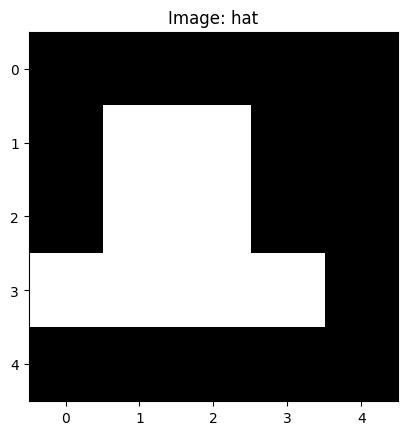

In [3]:
random_pos = False  # CHANGE ME
noise = 0.0         # CHANGE ME

classes = ["hat", "cup", "donut", "plus"]
fig, ax = plt.subplots()
subject = classes[np.random.choice(len(classes))]
ax.set_title(f"Image: {subject}")
ax.imshow(draw_picture(subject, random_pos, noise).view(5, 5, 1), cmap="gray")
plt.show()

Now, we'll define a dataset of these images. If you are interested, I left some comments to explain what's going on, but feel free to skip the details here.

In [4]:
class ImageDataset(Dataset):
    def __init__(self, n=1024, random_pos=True, random_noise=3e-2):
        super().__init__()        
        # Generate a bunch of random labels
        labels = torch.randn(n)
        labels[0.5 <= labels] = 3
        labels[(0 <= labels) & (labels < 0.5)] = 2
        labels[(-0.5 <= labels) & (labels < 0)] = 1
        labels[labels < -0.5] = 0
        labels = labels.to(int)
        # Generate the corresponding pictures
        dataset = torch.stack([
            draw_picture(classes[label], random_pos, random_noise)
            for label in labels
        ])
        # Normalize the data
        dataset = (dataset - torch.mean(dataset)) / torch.std(dataset)
        self.dataset = dataset
        self.classes = classes
        self.labels = labels
        self.n = n
        
    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        x = self.dataset[idx]
        y = self.labels[idx]
        return x, y

Next, let's define a super simple CNN. This is just one convolutional layer, followed by a max pool layer, then a single linear layer. I don't use any activation functions.

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 8, 3)
        self.pool = nn.MaxPool2d(3)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(8, 4)
        
    def forward(self, x):
        h = self.conv(x)
        h = self.pool(h)
        h = self.linear(self.flatten(h))
        return h

# Simplest problem
Let's create a dataset and a network. In this case, the positions of the objects in the pictures are fixed, and there is no noise.

In [6]:
dataset = ImageDataset(2**10, False, 0)
dataloader = DataLoader(dataset, 64, shuffle=True)
net = Net()

# To optimize the neural network, I am using an algorithm called "stochastic gradient descent".
# Read more: https://en.wikipedia.org/wiki/Stochastic_gradient_descent
optimizer = optim.SGD(net.parameters(), 1e-3, momentum=0.9, weight_decay=0.1, nesterov=True)

# To judge how "good" the neural network is, I am using a function called "cross entropy loss".
# Read more: https://en.wikipedia.org/wiki/Cross_entropy
criterion = nn.CrossEntropyLoss()

Then we can train the neural network.

In [7]:
def train(net, dataloader, num_epochs=20):
    for epoch in trange(num_epochs):
        for batch in dataloader:
            x, y = batch[0], batch[1]
            optimizer.zero_grad()
            yhat = net(x)
            loss = criterion(yhat, y)
            loss.backward()
            optimizer.step()

In [8]:
train(net, dataloader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:33<00:00,  1.69s/it]


Let's see how it did on some randomly selected data samples.

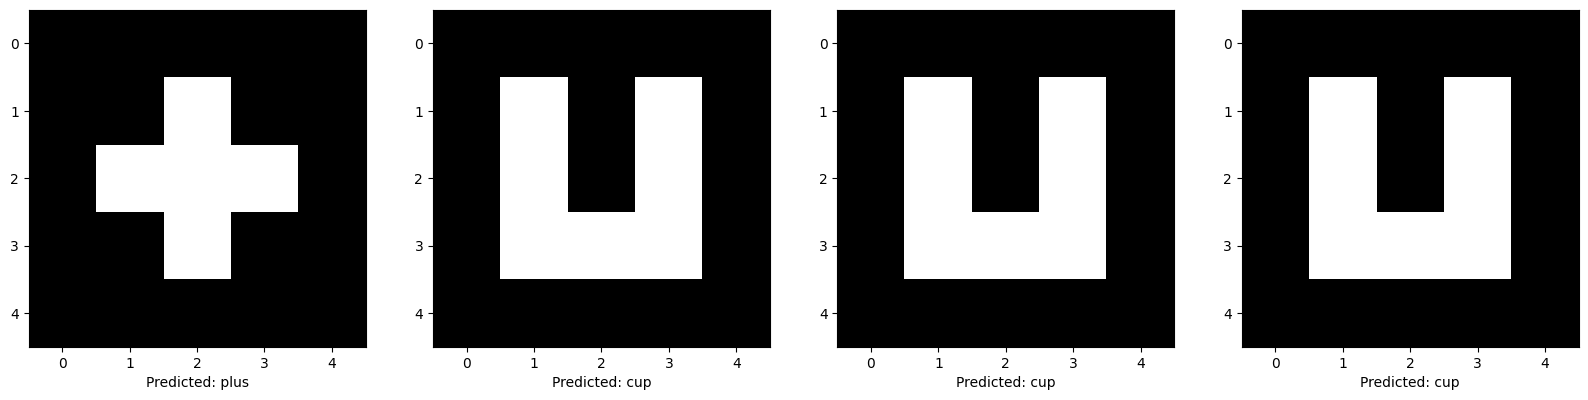

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

indices = torch.randint(len(dataset), (4,))
X = dataset[indices][0]
Y = dataset[indices][1]
yhats = net(X)
for i in range(len(indices)):
    axes[i].imshow(X[i].view(5, 5, 1), cmap="gray")
    axes[i].set_xlabel(f"Predicted: {dataset.classes[yhats[i].argmax()]}")

We can check its accuracy too.

In [10]:
def accuracy(dataset, net):
    correct, total = 0, len(dataset)
    for x, y in dataset:
        yhat = net(x.unsqueeze(0))
        if yhat.argmax() == y:
            correct += 1
    return correct / total

In [11]:
print(f"Accuracy: {accuracy(dataset, net):.2f}")

Accuracy: 1.00


The neural network got 100% accuracy. That's expected since the problem is so simple. Within a class, every image looks exactly the same. In fact, under this assumption, we could have solved this classification problem by hard-coding the answers!

What happens if we give the network an image where the subject is in a different location, or flipped?

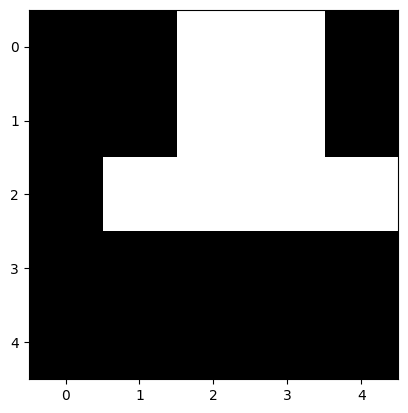

In [12]:
test_image1 = torch.tensor([
    [0, 0, 1, 1, 0],
    [0, 0, 1, 1, 0],
    [0, 1, 1, 1, 1],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]
], dtype=torch.float)

plt.imshow(test_image1.unsqueeze(2), cmap="gray")
plt.show()

In [13]:
yhat = net(test_image1.unsqueeze(0).unsqueeze(0))
dataset.classes[yhat.argmax()]

'cup'

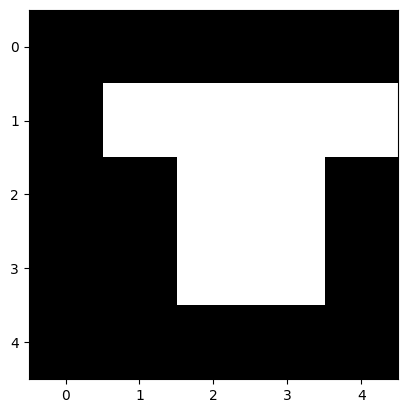

In [14]:
test_image2 = torch.tensor([
    [0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1],
    [0, 0, 1, 1, 0],
    [0, 0, 1, 1, 0],
    [0, 0, 0, 0, 0]
], dtype=torch.float)

plt.imshow(test_image2.unsqueeze(2), cmap="gray")
plt.show()

In [15]:
yhat = net(test_image2.unsqueeze(0).unsqueeze(0))
dataset.classes[yhat.argmax()]

'cup'

Clearly that's not good! If we move the hat around or flip it, the neural network is confused!

## Adding some noise
Holding everything else equal, let's see what happens if we add some noise to the images.

In [16]:
dataset = ImageDataset(2**10, False, 0.1)
dataloader = DataLoader(dataset, 64, shuffle=True)
train(net, dataloader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.14it/s]


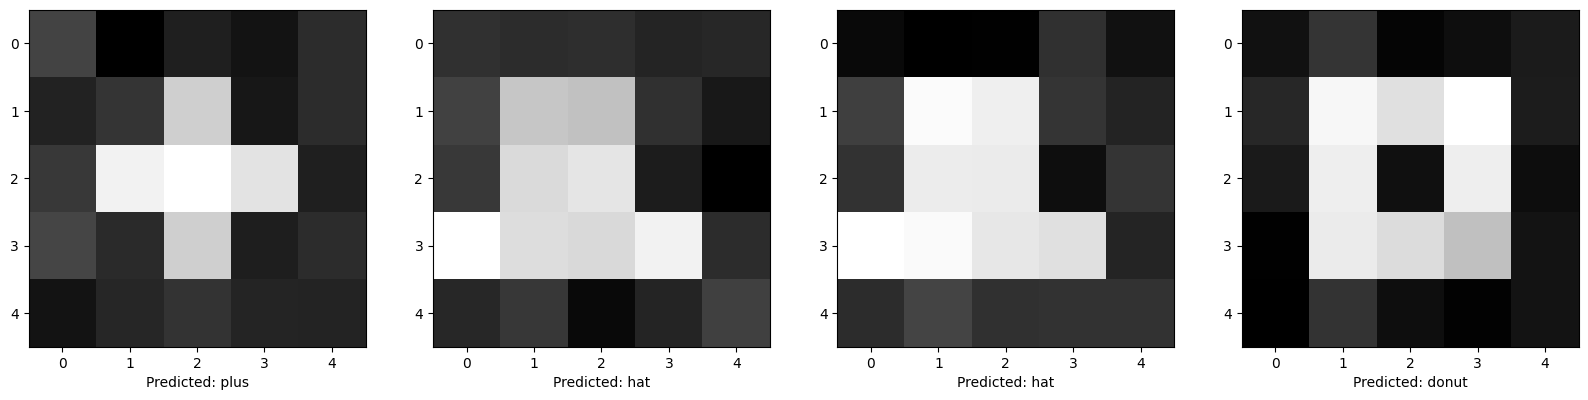

In [17]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

indices = torch.randint(len(dataset), (4,))
X = dataset[indices][0]
Y = dataset[indices][1]
yhats = net(X)
for i in range(len(indices)):
    axes[i].imshow(X[i].view(5, 5, 1), cmap="gray")
    axes[i].set_xlabel(f"Predicted: {dataset.classes[yhats[i].argmax()]}")

In [18]:
print(f"Accuracy: {accuracy(dataset, net):.2f}")

Accuracy: 1.00


Adding noise distorted the images somewhat, which would make hard-coding a solution a bit more difficult. However, each class is still clearly recognizable. It's not surprising that the neural network still achieved ~100% accuracy. What about images where the subject has moved or is flipped?

In [19]:
yhat = net(test_image1.unsqueeze(0).unsqueeze(0))
print(dataset.classes[yhat.argmax()])

yhat = net(test_image2.unsqueeze(0).unsqueeze(0))
print(dataset.classes[yhat.argmax()])

cup
cup


Okay, so it didn't help with that.

## Randomizing positions

Let's try randomizing positions.

In [20]:
dataset = ImageDataset(2**10, True, 0)
dataloader = DataLoader(dataset, 64, shuffle=True)
train(net, dataloader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.44it/s]


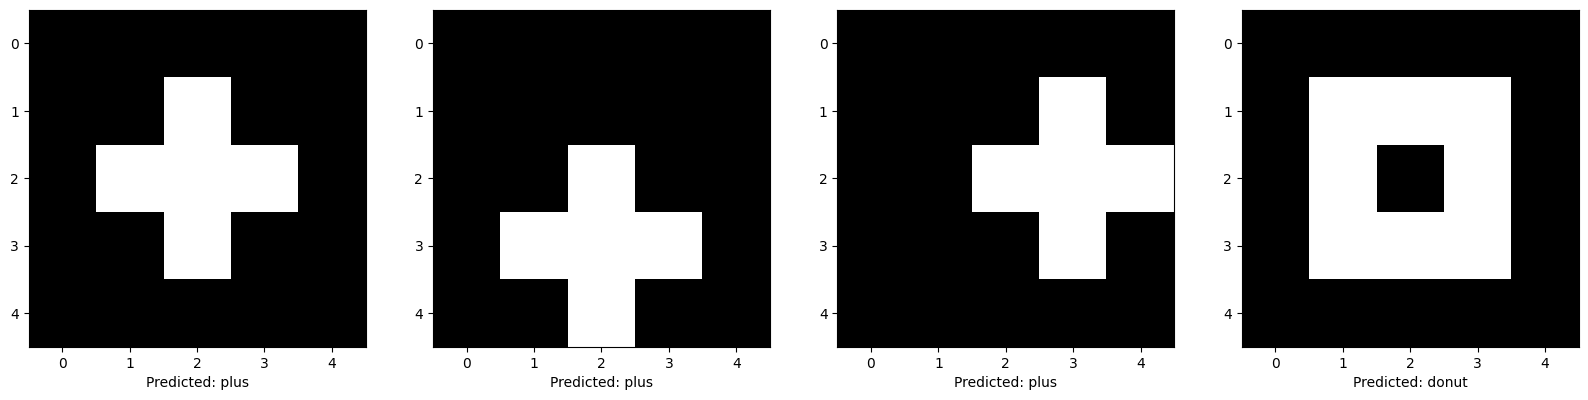

In [21]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

indices = torch.randint(len(dataset), (4,))
X = dataset[indices][0]
Y = dataset[indices][1]
yhats = net(X)
for i in range(len(indices)):
    axes[i].imshow(X[i].view(5, 5, 1), cmap="gray")
    axes[i].set_xlabel(f"Predicted: {dataset.classes[yhats[i].argmax()]}")

In [22]:
print(f"Accuracy: {accuracy(dataset, net):.2f}")

Accuracy: 0.96


In some cases, you might see accuracy drop by a decent amount!

In [23]:
yhat = net(test_image1.unsqueeze(0).unsqueeze(0))
print(dataset.classes[yhat.argmax()])

yhat = net(test_image2.unsqueeze(0).unsqueeze(0))
print(dataset.classes[yhat.argmax()])

hat
hat


Hey it helped!

## Noise and random positions
What happens if we combine both effects?

In [24]:
dataset = ImageDataset(2**10, True, 0.1)
dataloader = DataLoader(dataset, 64, shuffle=True)
train(net, dataloader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.64it/s]


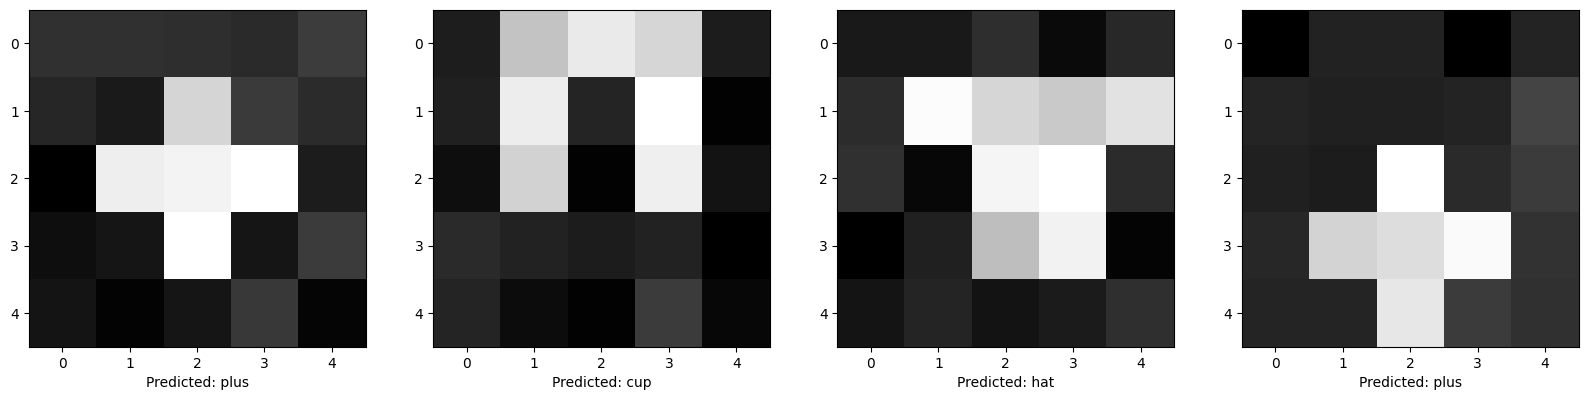

In [25]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

indices = torch.randint(len(dataset), (4,))
X = dataset[indices][0]
Y = dataset[indices][1]
yhats = net(X)
for i in range(len(indices)):
    axes[i].imshow(X[i].view(5, 5, 1), cmap="gray")
    axes[i].set_xlabel(f"Predicted: {dataset.classes[yhats[i].argmax()]}")

In [26]:
print(f"Accuracy: {accuracy(dataset, net):.2f}")

Accuracy: 0.96


Predictably, it's about the same as if we only randomized positions. A more interesting case study for noise would be on larger images, where we can have more variation on what each image in a class looks like.

In [27]:
yhat = net(test_image1.unsqueeze(0).unsqueeze(0))
print(dataset.classes[yhat.argmax()])

yhat = net(test_image2.unsqueeze(0).unsqueeze(0))
print(dataset.classes[yhat.argmax()])

hat
hat
